# **Stochastic Gradient Descent**

## **Data**

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing

In [5]:
california = fetch_california_housing()

df = pd.DataFrame(california.data, columns=california.feature_names)
df['TARGET'] = california.target
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,TARGET
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


In [6]:
print(california.DESCR) #Description

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

---

데이터 분포를 파악하기 위해, 1000개만 임의로 추출하여 페어 플롯을 그린다.

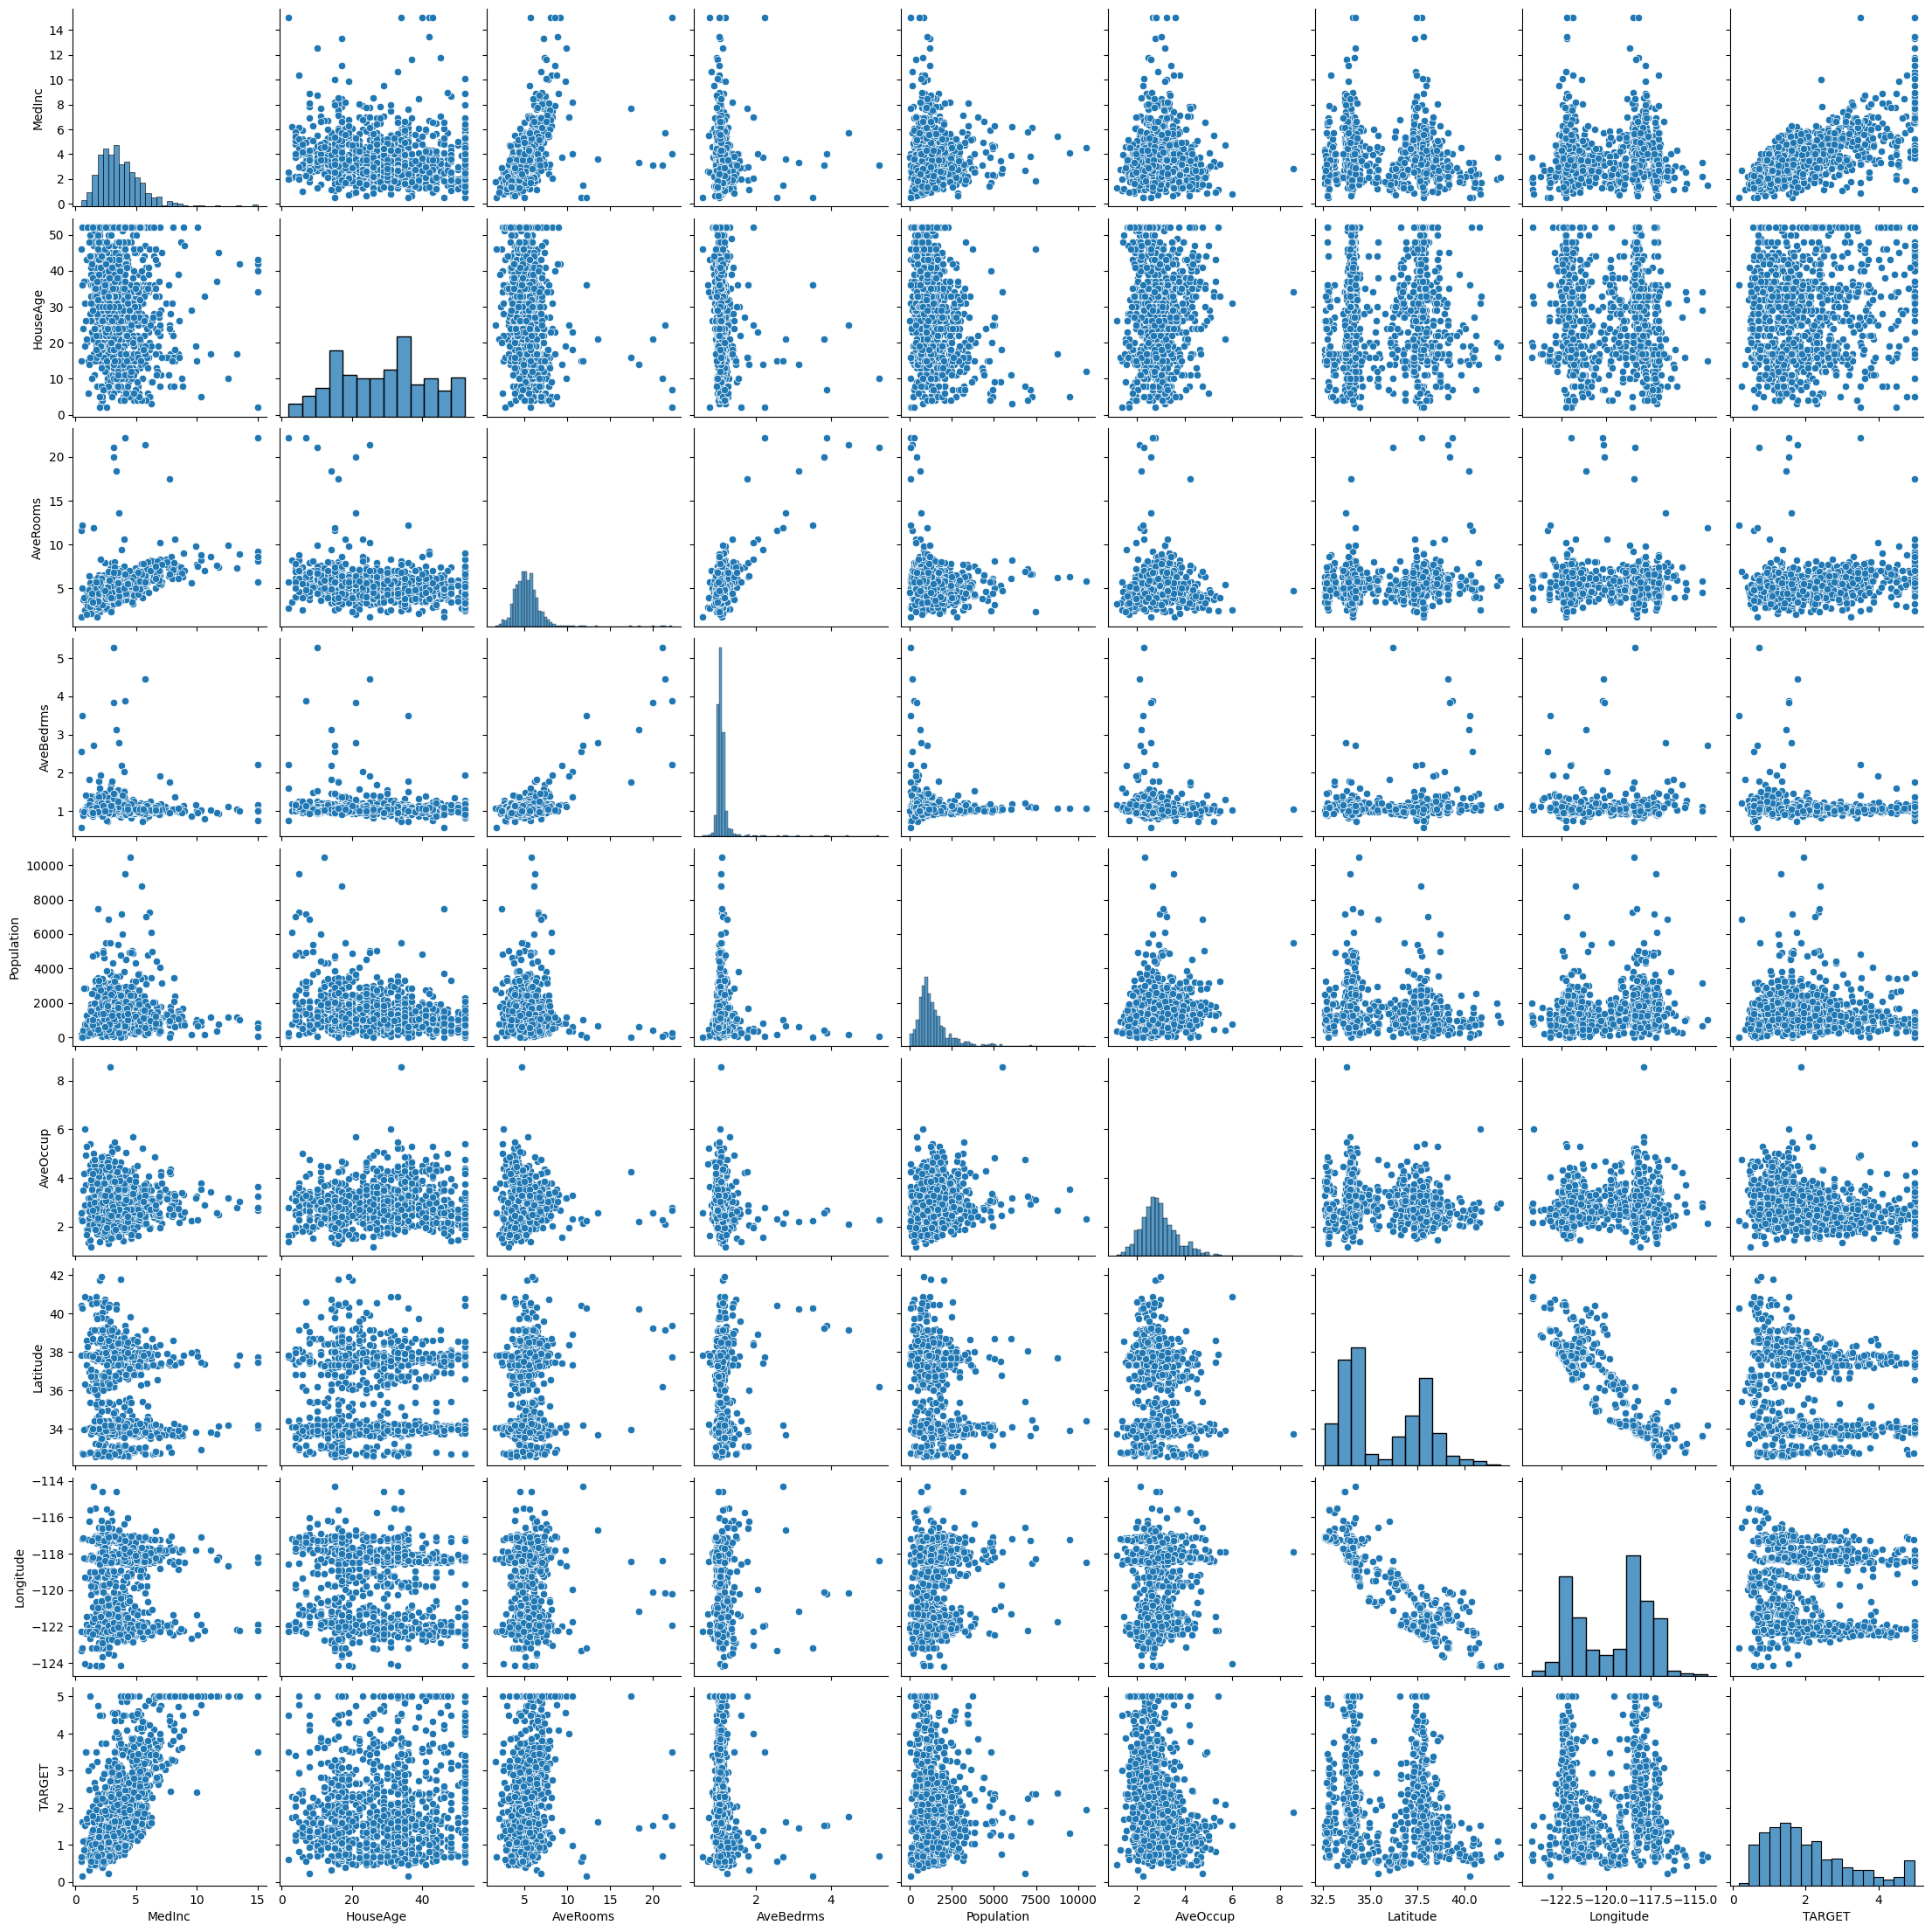

In [7]:
sns.pairplot(df.sample(1000))
plt.show()

스케일링을 적용하고 다시 데이터를 관찰해보자.

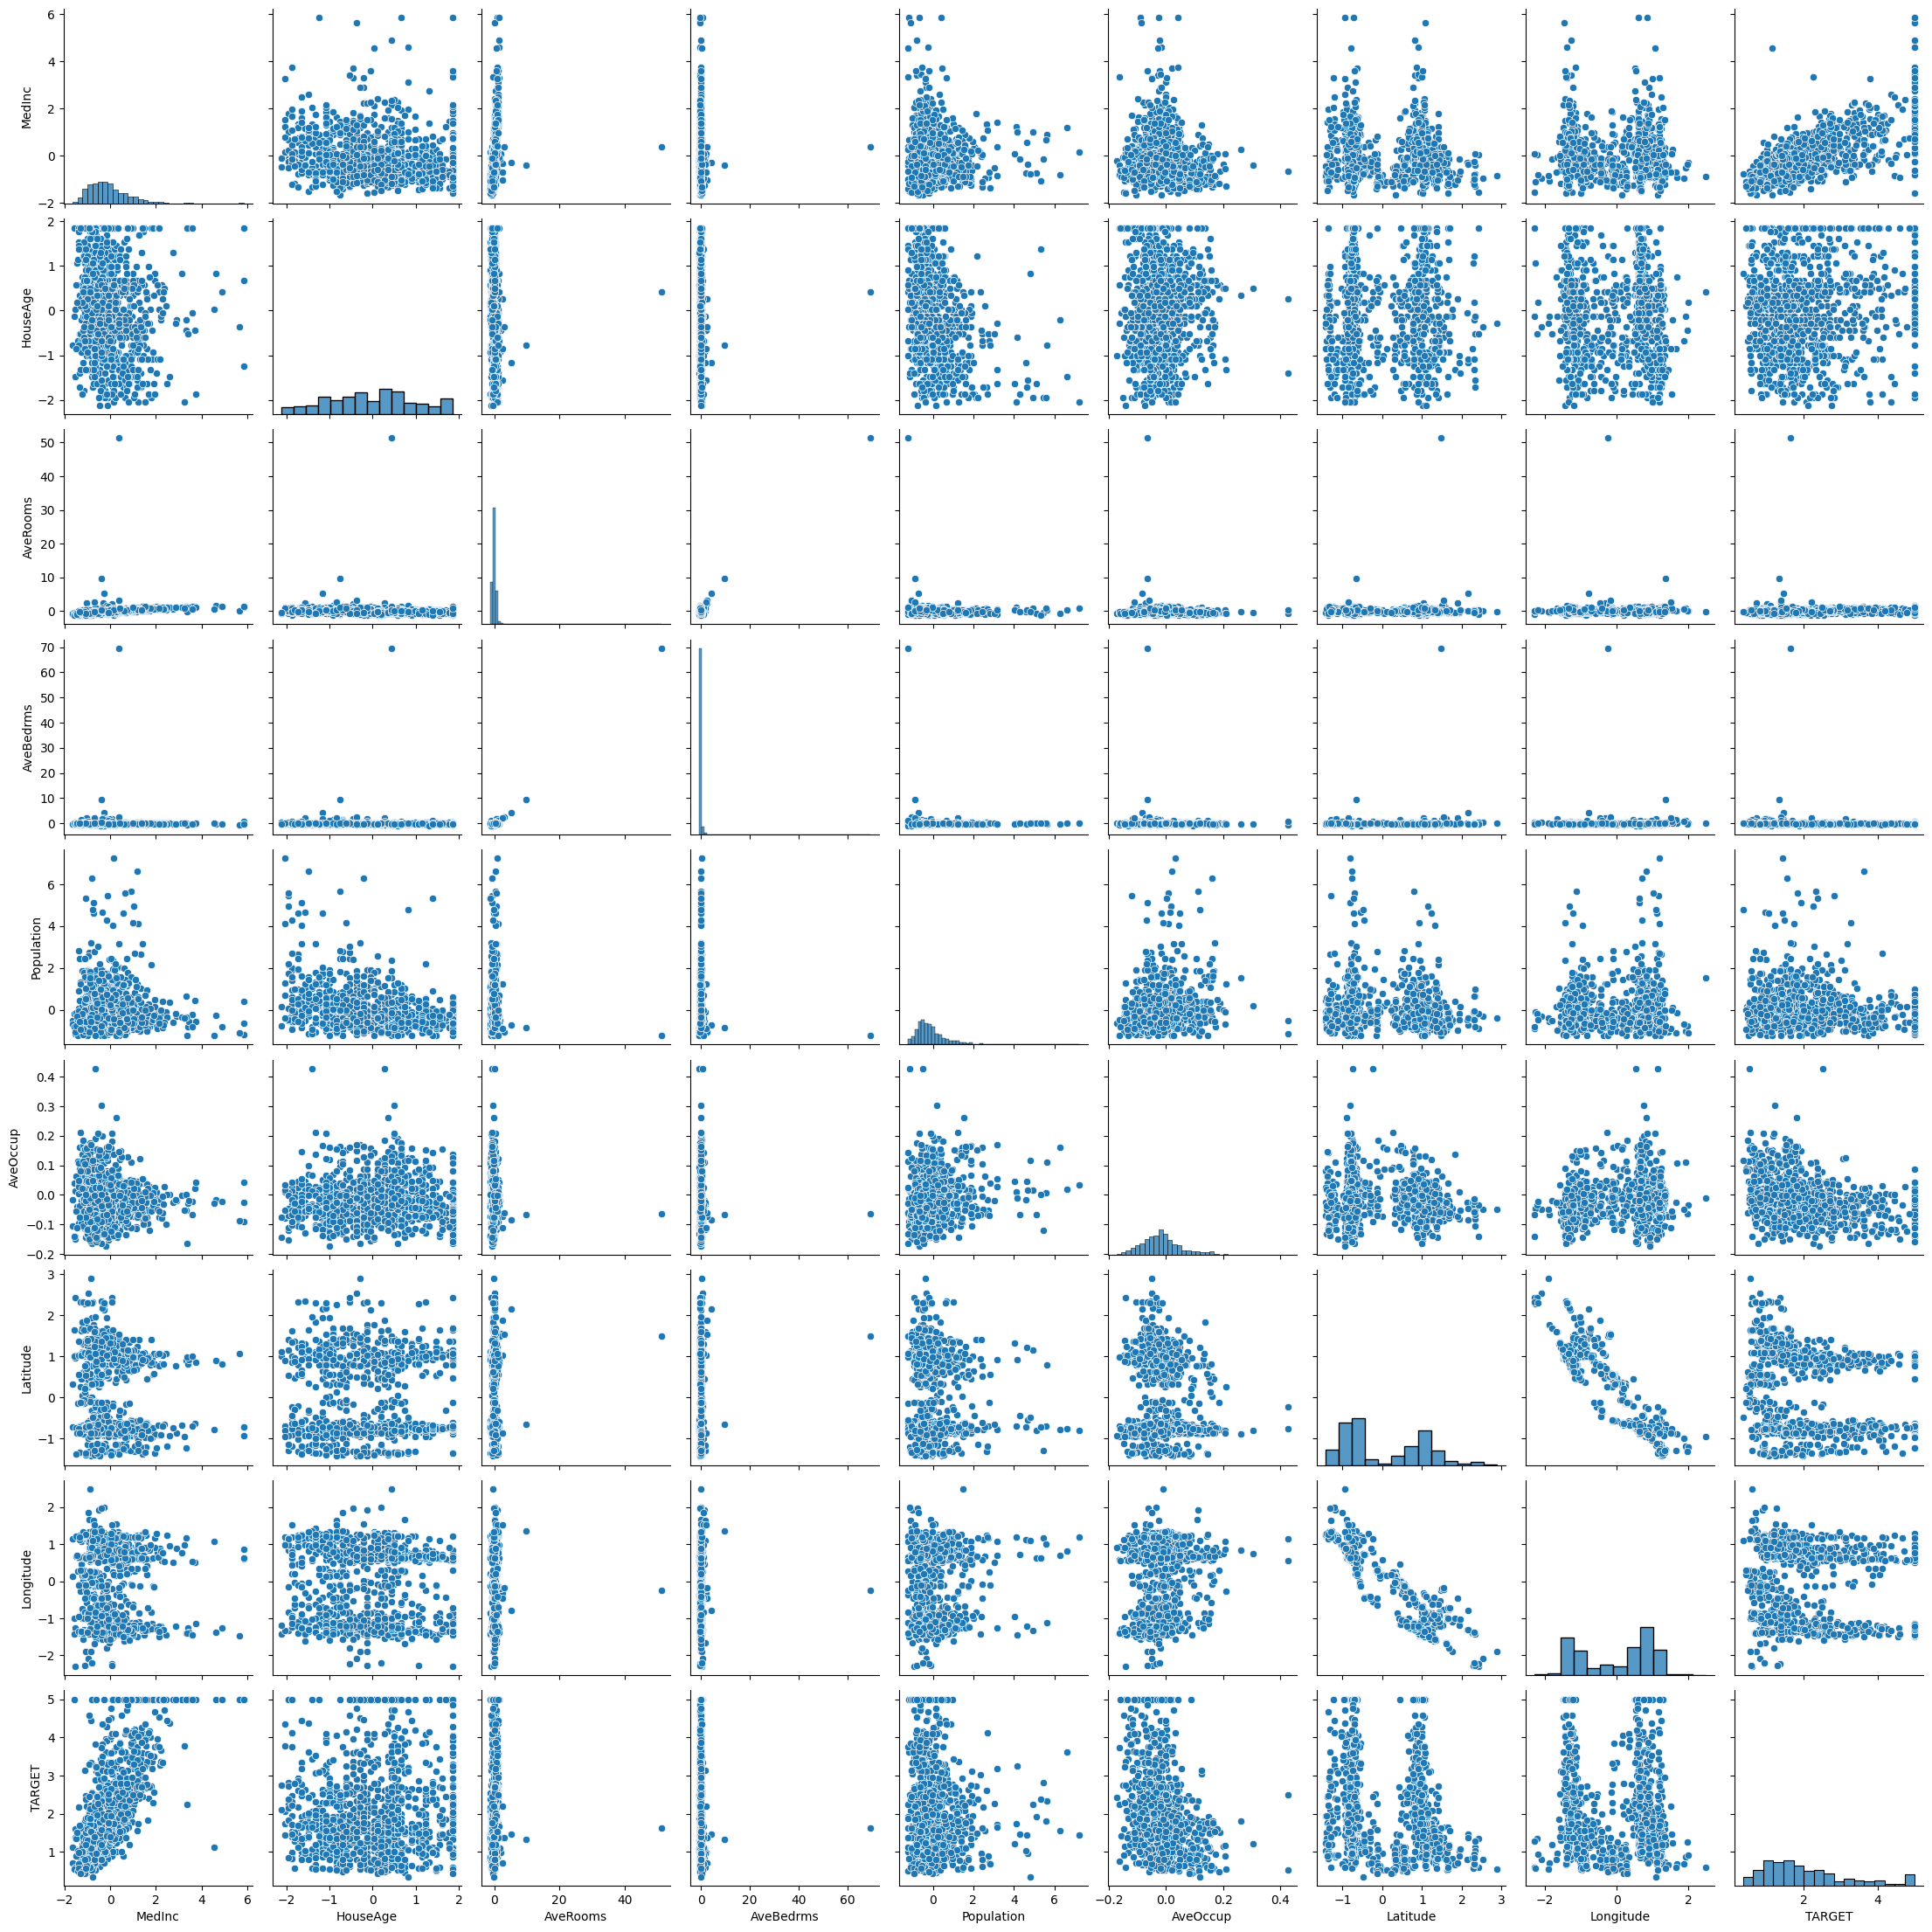

In [4]:
scaler = StandardScaler()
scaler.fit(df.values[:, :-1])
df.iloc[:, :-1] = scaler.transform(df.values[:, :-1]).round(4)
sns.pairplot(df.sample(1000))
plt.show()

## **Source Code**

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

**1. 데이터 준비 및 입출력 데이터 정의**

In [11]:
data = torch.from_numpy(df.values).float()
x = data[:, :-1]
y = data[:, -1:]

print(data.shape, x.shape, y.shape)

torch.Size([20640, 9]) torch.Size([20640, 8]) torch.Size([20640, 1])


**2. 하이퍼 파라미터 정의**

In [7]:
n_epochs = 4000
learning_rate = 1e-2
print_interval = 200
batch_size=256

**3. DNN 정의**

In [8]:
model = nn.Sequential(
    nn.Linear(x.size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6,5),
    nn.LeakyReLU(),
    nn.Linear(5,4),
    nn.LeakyReLU(),
    nn.Linear(4,3),
    nn.LeakyReLU(),
    nn.Linear(3, y.size(-1)), 
)

print(model)

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)


**4. 최적화 알고리즘 설정(SGD)**

In [9]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [10]:
import time
start = time.time()

**5. 에폭 루프 설정**

이전에는 전체 데이터를 한 번에 학습 시켰다.  
이번에는 데이터를 랜던하게 섞은 후, 미니 배치로 쪼개어 학습한다.  

`torch.randperm(x.size(0))`: 0부터 데이터 개수 -1까지의 숫자를 무작위 순서로 섞은 인덱스 텐서 생성  
`index_select`: 그 인덱스를 이용해 x, y를 같은 순서로 섞는다.   
`y_hat`: 각 배치의 예측값을 리스트로 모아둔다. 학습 종료 후 전체 결과를 하나로 합치게 된다.

In [11]:
for i in range(n_epochs):
    # Shuffling
    indices = torch.randperm(x.size(0))
    x_=torch.index_select(x, dim=0, index=indices)
    y_=torch.index_select(y, dim=0, index=indices)

    # Mini-batch spilit
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    
    y_hat = []
    total_loss = 0

    # Learning a Mini-batch
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += float(loss) # type casting into float. to prevent memory leak.
        y_hat += [y_hat_i]

    total_loss = total_loss / len(x_) # mean loss value during 1 epoch

    if(i+1) % print_interval == 0:
        print('Epoch %d/%d: loss=%.4e' %(i+1, n_epochs, total_loss))

y_hat = torch.cat(y_hat, dim=0)
y = torch.cat(y_, dim=0)

C:\Users\user\AppData\Local\Temp\ipykernel_12240\3732691660.py:20: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  total_loss += float(loss) # type casting into float. to prevent memory leak.


Epoch 200/4000: loss=3.1011e-01
Epoch 400/4000: loss=3.0407e-01
Epoch 600/4000: loss=3.0228e-01
Epoch 800/4000: loss=3.0044e-01
Epoch 1000/4000: loss=2.9944e-01
Epoch 1200/4000: loss=2.9791e-01
Epoch 1400/4000: loss=2.9719e-01
Epoch 1600/4000: loss=2.9532e-01
Epoch 1800/4000: loss=2.9376e-01
Epoch 2000/4000: loss=2.9200e-01
Epoch 2200/4000: loss=2.9018e-01
Epoch 2400/4000: loss=2.8944e-01
Epoch 2600/4000: loss=2.8866e-01
Epoch 2800/4000: loss=2.8776e-01
Epoch 3000/4000: loss=2.8758e-01
Epoch 3200/4000: loss=2.8771e-01
Epoch 3400/4000: loss=2.8759e-01
Epoch 3600/4000: loss=2.8671e-01
Epoch 3800/4000: loss=2.8643e-01
Epoch 4000/4000: loss=2.8578e-01


**6. 시각화**

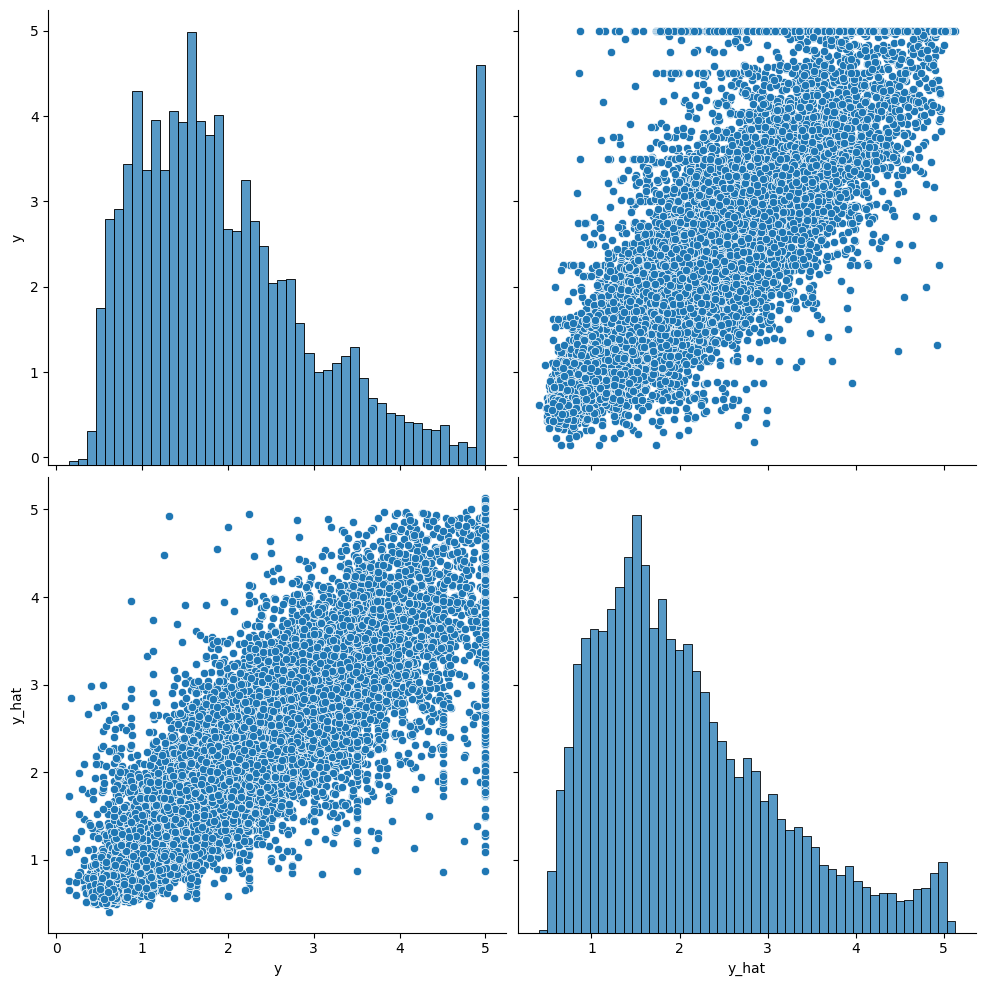

In [12]:
df = pd.DataFrame(torch.cat([y, y_hat], dim=1).detach().numpy(),
                  columns=["y", "y_hat"])
sns.pairplot(df, height=5)
plt.show()